In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaredsimpauco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jaredsimpauco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
raw_data = pd.read_csv("data/data.csv")
raw_data.head()

,book_id,text,birth_yr
0,84,"“And now, with the world before me, whither sh...",1797
1,84,"“You have been ill, very ill, and even the con...",1797
2,84,“I intended to reason. This passion is detrime...,1797
3,84,"“How is this? I must not be trifled with, and ...",1797
4,84,"“A few days after, the Turk entered his daught...",1797


## EDA 1: Distribution of Number of Excerpts

In [3]:
excerpt_count = raw_data.copy()

# Getting counts for the number of excerpts #
excerpt_count = (
    excerpt_count
    .groupby('book_id')[['text']]
    .count()
    .reset_index()['text']
    .value_counts()
    .to_frame()
    .reset_index()
)

# Renaming columns #
excerpt_count = (
    excerpt_count
    .rename(columns=
            {'index': 'Number of Excerpts',
             'text': 'Count'}
    )
)

excerpt_count.head()

,Number of Excerpts,Count
0,3,838
1,12,203
2,9,181
3,6,78
4,11,75


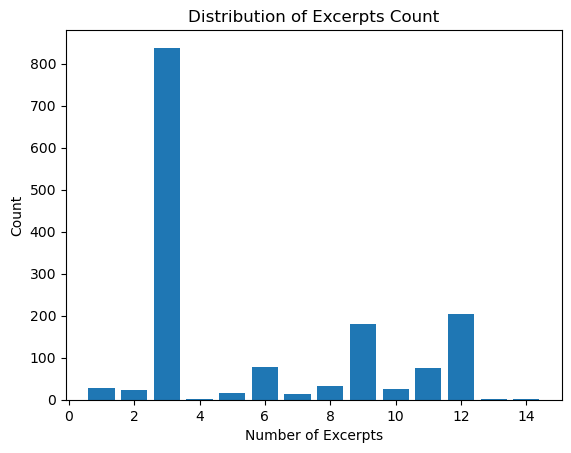

In [4]:
plt.bar(x='Number of Excerpts', height='Count', data=excerpt_count);
plt.xlabel('Number of Excerpts');
plt.ylabel('Count');
plt.title('Distribution of Excerpts Count');

While we tried to ensure that there were only 3 excerpts per book, there are some with more or less than 3. Some books have less than 3 due to our initial data cleaning, in which when wrangling the data, some excerpts were just the table of contents. Since we have decided to omit them from our final dataset, this resulted in some books having less than 3 excerpts. There are a good amount of books that have more than 3 excerpts due to their popularity in multiple centuries. To elaborate, a book might be listed twice due to its popularity and more people wanting to read the book. Because of this, the book was wrangled more than once, and more excerpts have been pulled for the book.

## EDA 2: Number of Excerpts Per Century

In [5]:
centuries = raw_data.copy()

# Creaing conditions #
centuries_cond = [
    (centuries['birth_yr'] >= 1500) & (centuries['birth_yr'] < 1600),
    (centuries['birth_yr'] >= 1600) & (centuries['birth_yr'] < 1700),
    (centuries['birth_yr'] >= 1700) & (centuries['birth_yr'] < 1800),
    (centuries['birth_yr'] >= 1800) & (centuries['birth_yr'] < 1900),
    (centuries['birth_yr'] >= 1900) & (centuries['birth_yr'] < 2000)
]

# Creating century column #
centuries['Century'] = np.select(centuries_cond, ['16th', '17th', '18th', '19th', '20th'], default='null')

# Removing null values (outliers) #
centuries = centuries[centuries['Century'] != 'null']

# Getting counts #
centuries = (
    centuries
    .groupby('Century')[['text']]
    .count()
    .reset_index()
    .rename(columns={
        'text': 'Count'
        }
    )
)

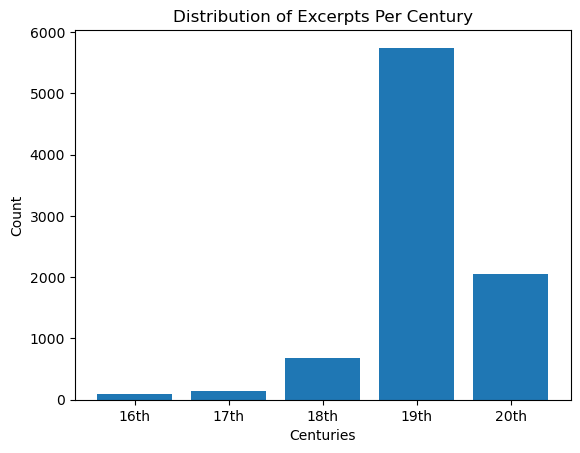

In [6]:
plt.bar(x='Century', height='Count', data=centuries);
plt.xlabel('Centuries');
plt.ylabel('Count');
plt.title('Distribution of Excerpts Per Century');

There was a particular outlier in our dataset in that one of the books were from the BCE time period. It will be omitted since it is the only text from that time frame and would only prove to mess with our model later down the line.

## Model Exploration

In [7]:
data = raw_data.copy()
data['text'] = data['text'].str.strip()
data = data.drop(4996)

In [8]:
# Create a copy of the dataset to do text analysis on
data_tfidf = data.copy()

# Process the dataset by removing punctuation for TF-IDF
def preprocess(text):
    text = re.sub(r'[^A-Za-z0-9]+', " ", text)
    text = text.lower()
    return text
data_tfidf["text"] = data_tfidf.get("text").apply(preprocess)
data_tfidf.head()

,book_id,text,birth_yr
0,84,and now with the world before me whither shou...,1797
1,84,you have been ill very ill and even the const...,1797
2,84,i intended to reason this passion is detrimen...,1797
3,84,how is this i must not be trifled with and i ...,1797
4,84,a few days after the turk entered his daughte...,1797


In [21]:
# Create a standard TF-IDF using arbitrary parameters
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    max_features=2000,
    tokenizer=nltk.tokenize.word_tokenize,
    stop_words=stopwords.words("english")
)

In [22]:
X = tfidf.fit_transform(data_tfidf["text"])
y = np.array(data_tfidf["birth_yr"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [23]:
model1 = RandomForestRegressor(max_depth=80, criterion='squared_error', random_state=1)
model1.fit(X_train, y_train)

RandomForestRegressor(max_depth=80, random_state=1)

In [24]:
y_train_pred1 = model1.predict(X_train)
y_test_pred1 = model1.predict(X_test)

In [25]:
def RMSE(y_pred, y):
    return np.sqrt(np.sum(np.square(y - y_pred)) / y.shape[0])

In [26]:
print(f"Training RMSE: {RMSE(y_train_pred1, y_train)}")
print(f"Test RMSE: {RMSE(y_test_pred1, y_test)}")

Training RMSE: 36.60502910157714
Test RMSE: 114.34667541130021


In [27]:
model2 = RandomForestClassifier(max_depth=70, criterion='gini', random_state=1)
model2.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, random_state=1)

In [28]:
y_train_pred2 = model2.predict(X_train)
y_test_pred2 = model2.predict(X_test)

In [29]:
print(f"Training RMSE: {RMSE(y_train_pred2, y_train)}")
print(f"Test RMSE: {RMSE(y_test_pred2, y_test)}")

Training RMSE: 8.825880746139383
Test RMSE: 125.62475295516354


In [18]:
# hyperparameters = {
#     'max_depth': [50, 60, 70],
#     'criterion': ['gini'],
# }

In [19]:
# searcher = GridSearchCV(RandomForestClassifier(), hyperparameters)
# searcher.fit(X_train, y_train)

In [20]:
# searcher.best_params_